# 3D example of a parallel plate capacitance

TODO: Add tutorial with mixed points

TODO: Add tutorial where update is used

# Geometry: 

Start by defining the geometry of the system.

This can be done in two ways: 
    
- By defining a function taking as parameter a numpy array representing a set of coordinates and returning a boolean. True if the coordinate is within the defined region. 
        
- By creating an instance of a sublcass of poisson.Shape, c.f. poisson.continuous.shape. 

The advantage of the latter is that logical operations are accepted, e.g.

In [1]:
from poisson.continuous import shapes

A = shapes.Rectangle(length=(5, 2, 5))
B = shapes.Rectangle(length=(5, 5, 5), corner=(0, 2.001, 0))
C = shapes.Rectangle(length=(5, 2, 5), corner=(0, 7.001, 0))


VoronoiMesh version 0.1
DiscretePoisson version 0.3
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1


The logical operations that are allowed between Shape instances are:

- +: addition
- \- : subtraction
- & : and (same as addition)
- | : or 
- ^ : xor

One can also apply a not operation ~ to a individual Shape instance

A few examples :

In [2]:
import numpy as np

coord = np.vstack((np.linspace(0, 10, 100), np.linspace(0, 10, 100), np.linspace(0, 10, 100))).T

print(coord)
print(A(coord))
print(B(coord))
print((A + B)(coord))
print((A & B)(coord))
print((A - B)(coord))
print((A ^ B)(coord))
print((A | B)(coord))


[[ 0.          0.          0.        ]
 [ 0.1010101   0.1010101   0.1010101 ]
 [ 0.2020202   0.2020202   0.2020202 ]
 [ 0.3030303   0.3030303   0.3030303 ]
 [ 0.4040404   0.4040404   0.4040404 ]
 [ 0.50505051  0.50505051  0.50505051]
 [ 0.60606061  0.60606061  0.60606061]
 [ 0.70707071  0.70707071  0.70707071]
 [ 0.80808081  0.80808081  0.80808081]
 [ 0.90909091  0.90909091  0.90909091]
 [ 1.01010101  1.01010101  1.01010101]
 [ 1.11111111  1.11111111  1.11111111]
 [ 1.21212121  1.21212121  1.21212121]
 [ 1.31313131  1.31313131  1.31313131]
 [ 1.41414141  1.41414141  1.41414141]
 [ 1.51515152  1.51515152  1.51515152]
 [ 1.61616162  1.61616162  1.61616162]
 [ 1.71717172  1.71717172  1.71717172]
 [ 1.81818182  1.81818182  1.81818182]
 [ 1.91919192  1.91919192  1.91919192]
 [ 2.02020202  2.02020202  2.02020202]
 [ 2.12121212  2.12121212  2.12121212]
 [ 2.22222222  2.22222222  2.22222222]
 [ 2.32323232  2.32323232  2.32323232]
 [ 2.42424242  2.42424242  2.42424242]
 [ 2.52525253  2.52525253

From this one can now define a continuous geometry of your system. 
This is done by initializing a ContinuousGeometry instance, c.f poisson.continuous.geometry. 

In the latter one has to define, for a parallel plate capacitance :

- The total space occupied by the system -> In this case space = A + B + C

- The regions where the voltage will be fixed -> voltage = [A, C] or voltage = {'elc1':A, 'elec2':} 
    
    obs: the dictionary allows for the names of the voltages sub-regions to be chosen. 
        

- The relative permittivity in each region -> dielectric = [(A + C, 1), (B, 12)]. The first element  in the tuple is either a function as explained previosuly or a Shape subclass instance. The second element is the relative permittivity.
        
There is no need to defined the charge regions since any zone in space but not in voltage is by default a region where the charge is fixed.

In [3]:
import poisson
import matplotlib.pyplot as plt

con_geo = poisson.ContinuousGeometry(space = A + B + C, 
                                     voltage={'elect1':A, 'elect2':C},
                                     dielectric=[(A+C, 1), (B, 12)])

One must also define a list of points to where the ContinuousGeometry instance will be evaluated on. Those points also
correspond to the center of the volume element in the finite volume mesh that will be created later on. 

One can simply create a numpy array containing the coordinates of each point or make a GridBuilder instance. 
In the latter (c.f. poisson.continuous.grid) one can generate a list of coordinates from:
    
- A function (such as the one defined above) or a Shape instance
- A step betwen the points 
- A bounding box, e.g. [xmin, xmax, ymin, ymax, zmin, zmax]

In [4]:

from poisson import plot as p_plt

bbox_A = [0, 5, 0, 5, 0, 5]
bbox_B = [0, 5, 2, 8, 0, 5]
bbox_C = [0, 5, 5, 10, 0, 5]
grid = poisson.GridBuilder(meshs = [(bbox_A, 1, A, 1),  # second argument the step and fourth argument is the label
                                    (bbox_B, 1, B, 2),
                                    (bbox_C, 1, C, 3)])

# Acess the points by calling the GridBuilder instance -> grid()

In [5]:
# plot the 3D grid -> This uses mayavi, 
# c.f. http://docs.enthought.com/mayavi/mayavi/tips.html#using-mayavi-in-jupyter-notebooks
p_plt.points_3D_mavi(cls_inst=grid, scale_factor = 0.05)
plt.show()

# One can also use the coordinates in grid to plot the ContinuousGeometry, i.e.
con_geo.plot(plot_type='3D', points=grid(), scale_factor = 0.05)
plt.show()

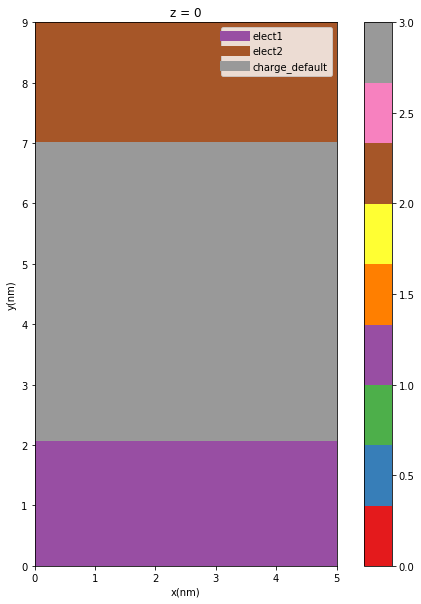

In [6]:
# Or plot a 2D cut
con_geo_cut = con_geo.plot(plot_type='2D', bbox=[0, 5, 0, 9])
con_geo_cut(variable=0)
plt.show()


# Discrete Problem

One must now discretize the continuous geometry. In order to do so we can create an instance 
of poisson.DiscretePoisson, c.f. poisson.discrete.discrete_poisson. When initialized the DiscretePoisson class will build the capacitance matrix associated with the system. 

In order to do so one only needs to provide the ContinuousGeometry and a GridBuilder instance. 
One can also remove redundant points by using the selection parameter. 
In order to remove points within the voltage regions one can define 
selection as -> selection = {'Neuman-Dirichlet':[['voltage', '*']]}. 

Here the dictionary key imposes the method that will be used to remove the points. 'voltage' means that we will apply the afformented method to points in the voltage region and '\*' means that we will do so for all 'voltage' sub-regions. One could replace '\*' by ['elect1'] to apply the 'Neuman-Dirichlet' method to only the 'elect1' sub-region'. 


In [7]:
discrete_prob = poisson.DiscretePoisson(con_geo, grid=grid, 
                                        selection = {'Neuman-Dirichlet':[['voltage', '*']]})

Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
{'Neuman-Dirichlet': [['voltage', '*']]}
Done Neuman - Dirichlet refinement
Done calculating surface
Done calculating distance
Done calculating capacitance matrix


# Solving the discrete problem

In order to solve the discrete problem one can create an instance of poisson.LinearProblem, c.f. poisson.discrete.linear_problem.

In order to do this one must give as parameters, for a parallel capacitance problem:

- An instance of DiscreteProblem
- The voltage values at the electrodes
- A boolean parameter indicating if the charge is given as density of charge or as a number of charge contained in a volume element. For more information on how to defined the charge density c.f. Report. 

The charge values do not need to be given as their default value is 0

When initializing LinearPoblem the problem will be, by default, solved. 

In [8]:
linear_prob = poisson.LinearProblem(discrete_poisson=discrete_prob, voltage_val=[(A, 5), (C, -5)], 
                                   is_charge_density=True) # is_charge_density is by default true

# In order to recover the charge and voltage value at each point
points_charge = linear_prob.points_charge 
points_voltage = linear_prob.points_voltage

# In oder to recover the volume of each cell
points_volume = linear_prob.discrete_poisson.mesh.points_hypervolume

# Saving the results in a .vtu format (compatible with ParaView  -> h ttps://www.paraview.org/)
linear_prob.save_to_vtk(filename='/home/alacerda/Desktop/Poisson_solver/Poisson_Solver/poisson/examples/example_cp')

New instance created
Solver : MUMPS


# Plotting
TODO: Explain the parameters given to plot functions ? For now c.f doc

In [9]:
#3D plot
linear_prob.plot_3d(titles=('Voltage', 'Charge'), scale_factor=(0.05, 1))

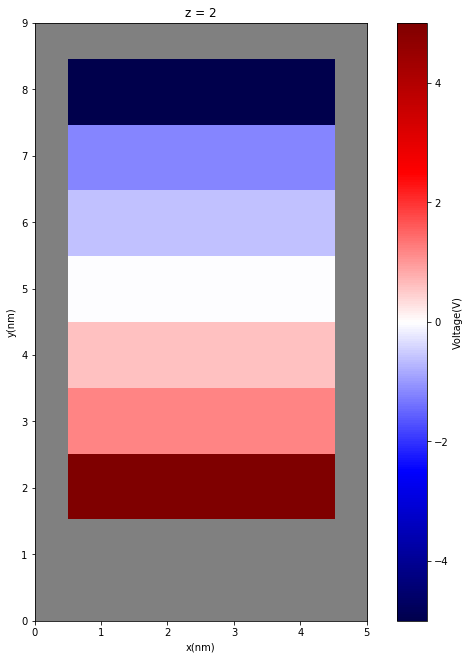

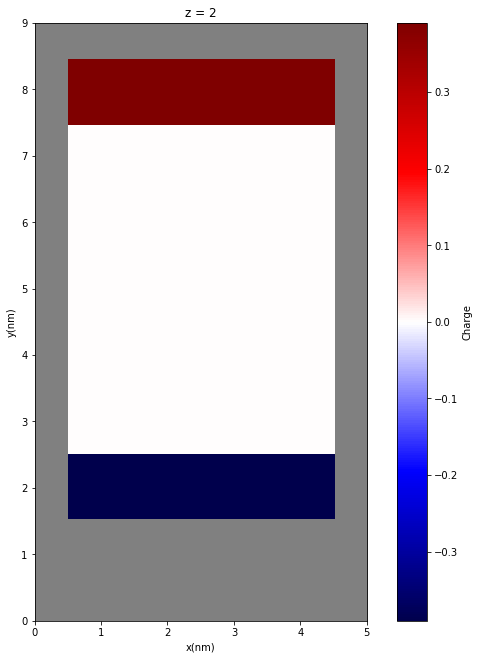

In [10]:
#2D cut
plot_volt, plot_charge = linear_prob.plot_cut_2d(direction=2, npoints=[200, 200])
plot_volt(variable=2, colorbar_label='Voltage(V)')
plot_charge(variable=2, colorbar_label='Charge')
plt.show()

{'marker': 'x', 'label': 'Voltage simulation - center', 'linestyle': 'None', 'color': 'r'}
{'marker': '.', 'label': 'Voltage simulation - bbox', 'linestyle': 'None', 'color': 'k'}
{'marker': 'x', 'label': 'Charge simulation - center', 'linestyle': 'None', 'color': 'm'}
{'marker': '.', 'label': 'Charge simulation - bbox', 'linestyle': 'None', 'color': 'b'}


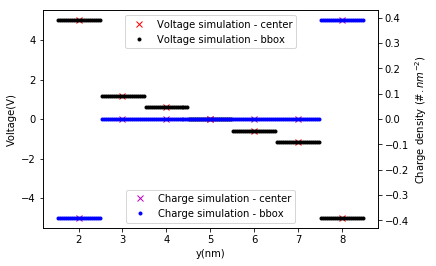

In [11]:
# 1D cut
# If bbox parameter not specified -> plot the value at the center of the volume cell.
plot_voltage, plot_charge = linear_prob.plot_cut_1d(directions=[0, 2])

# If bbox specified -> generates a list of points and find which volume
# cell they belong to. Take the value at the center of that cell as their
# voltage and charge value.
plot_voltage_bb, plot_charge_bb = linear_prob.plot_cut_1d(
        directions=[0, 2], bbox='default')

fig2 = plt.figure()
ax_voltage = fig2.add_subplot(111)

t, data_volt = plot_voltage(
        variables= [2, 2], ax = ax_voltage, marker='x',
        label='Voltage simulation - center', linestyle='None', color='r',)

t, data_volt = plot_voltage_bb(
        variables= [2, 2], ax = ax_voltage, marker='.',
        label='Voltage simulation - bbox', linestyle='None', color='k',)

ax_voltage.set_xlabel('{0}(nm)'.format('y'))
ax_voltage.set_ylabel('Voltage(V)')
ax_voltage.legend(loc='upper center')

ax_charge = ax_voltage.twinx()

t, data_charge = plot_charge(
        variables = [2, 2], ax = ax_charge, marker='x',
        label='Charge simulation - center', linestyle='None',  color='m',)

t, data_charge = plot_charge_bb(
        variables = [2, 2], ax = ax_charge, marker='.',
        label='Charge simulation - bbox', linestyle='None',  color='b',)

ax_charge.set_xlabel('{0}(nm)'.format('y'))
ax_charge.set_ylabel(r'Charge density $(\#.nm^{{{-2}}})$')
ax_charge.legend(loc='lower center')

plt.show()

We can also add a thrid electrode to make things more interesting

Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
{'Neuman-Dirichlet': [['voltage', '*']]}
Done Neuman - Dirichlet refinement
Done calculating surface
Done calculating distance
Done calculating capacitance matrix
New instance created
Solver : MUMPS


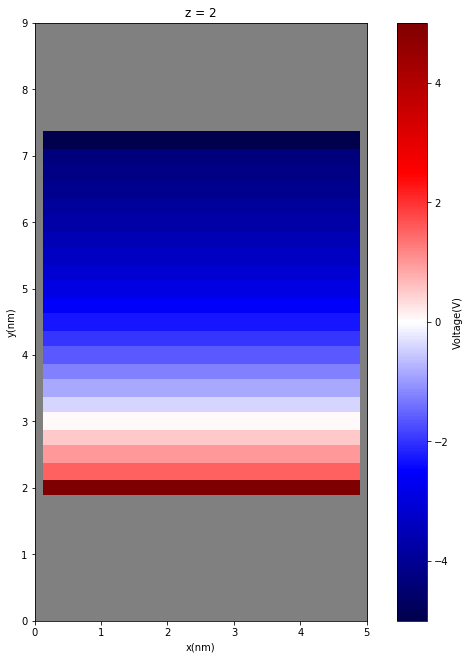

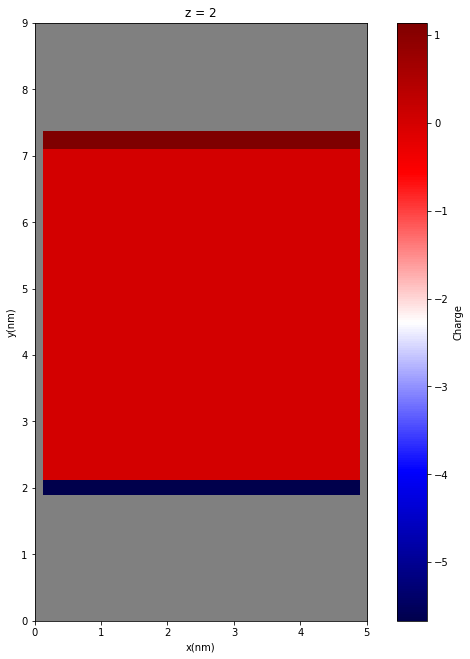

In [24]:
D = shapes.Rectangle(length=(5, 5, 2), corner=(0, 2.001, 5.001))

con_geo = poisson.ContinuousGeometry(space = A + B + C + D, 
                                     voltage={'elect1':A, 'elect2':C, 'elec_sup': D},
                                     dielectric=[(A+C+D, 1), (B, 12)])

bbox_A = [0, 5, 0, 5, 0, 5]
bbox_B = [0, 5, 2, 8, 0, 5]
bbox_C = [0, 5, 5, 10, 0, 5]
bbox_D = [0, 5, 2, 8, 5, 7]
grid = poisson.GridBuilder(meshs = [(bbox_A, 0.25, A, 1),  # second argument the step and fourth argument is the label
                                    (bbox_B, 0.25, B, 2),
                                    (bbox_C, 0.25, C, 3),
                                    (bbox_D, 0.25, D, 4)])

con_geo.plot(plot_type='3D', points=grid(), scale_factor = 0.05)
plt.show()

discrete_prob = poisson.DiscretePoisson(con_geo, grid=grid, 
                                        selection = {'Neuman-Dirichlet':[['voltage', '*']]})

linear_prob = poisson.LinearProblem(discrete_poisson=discrete_prob, voltage_val=[(A, 5), (C, -5), (D, -10)], 
                                   is_charge_density=True) # is_charge_density is by default true

plot_volt, plot_charge = linear_prob.plot_cut_2d(direction=2, npoints=[200, 200])
plot_volt(variable=2, colorbar_label='Voltage(V)')
plot_charge(variable=2, colorbar_label='Charge')
plt.show()

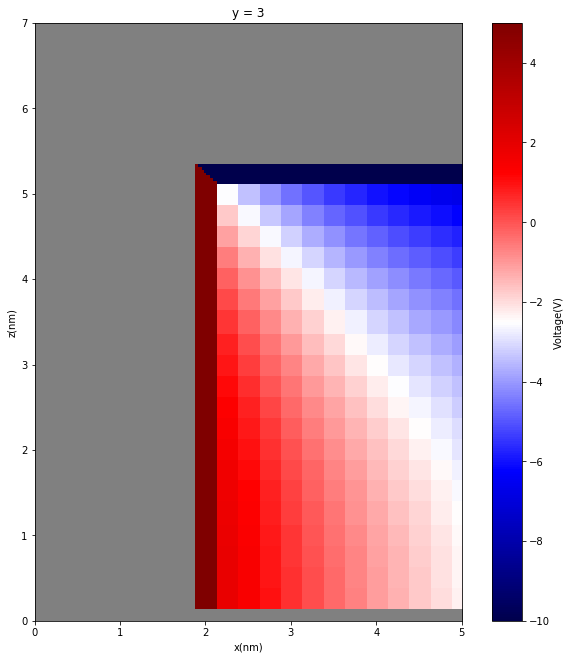

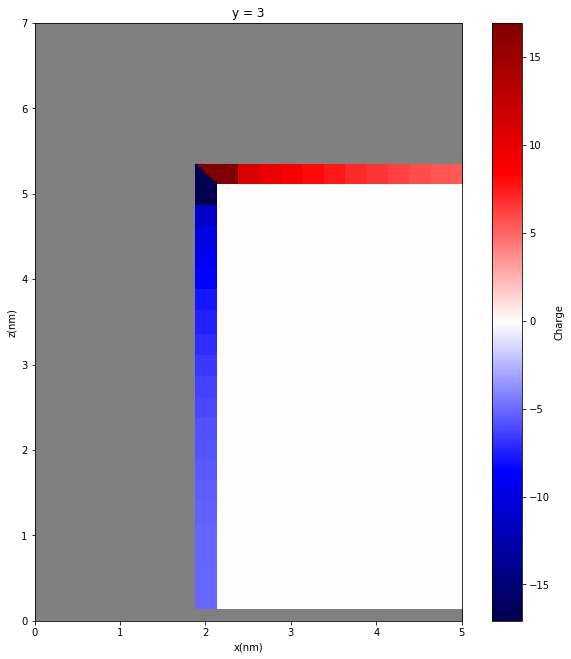

In [26]:
plot_volt, plot_charge = linear_prob.plot_cut_2d(direction=1, npoints=[200, 200])
plot_volt(variable=3, colorbar_label='Voltage(V)')
plot_charge(variable=3, colorbar_label='Charge')
plt.show()